In [1]:
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, Normalize
from math import log10
import random
import itertools

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from torch.utils.data import DataLoader, Dataset

plt.ion()

In [2]:
class DynamicPlot:
    def __init__(self):
        self.plots = {}
        self.fig = None
        
    def update(self, name, data_x, data_y):
        if name in self.plots:
            self.plots[name][0].append(data_x) 
            self.plots[name][1].append(data_y)
        else:
            self.plots[name] = [[data_x], [data_y]]
            
    def draw(self):
        if self.fig:
            self.fig.clear()
        else:
            self.fig = plt.figure(figsize=(10,10))
        n_plots = len(set(name.split('_')[0] for name in self.plots))
        groups = {}
        for name in self.plots:
            prefix = name.split('_')[0]
            suffix = name.split('_')[1]
            if not prefix in groups:
                groups[prefix] = {'ax': self.fig.add_subplot(n_plots, 1, len(groups) + 1)}
            groups[prefix]['ax'].plot(self.plots[name][0], self.plots[name][1], label = suffix)
            groups[prefix]['ax'].set_title(prefix, loc='right')
            groups[prefix]['ax'].legend()
        
        plt.subplots_adjust(hspace=0.5)
        self.fig.canvas.draw()
                
            
class DynamicImage:
    def __init__(self, max_images):
        self.fig = None
        self.names = []
        self.images = {}
        self.max_images = max_images
        
        
    def update(self, name, image):
        self.images[name] = image
        if not name in self.names and len(self.names) == self.max_images:
            del self.images[self.names[0]]
            self.names = self.names[1:]
        self.names.append(name)
        
    def draw(self):
        if self.fig:
            self.fig.clear()
        else:
            self.fig = plt.figure(figsize=(10,10))
        axes = {}
        for idx, name in enumerate(self.names):
            axes[name] = self.fig.add_subplot(len(self.names), 1, idx + 1)
            axes[name].imshow(self.images[name])
            axes[name].set_title(name, loc='right')
            
        plt.subplots_adjust(hspace=0.5)
        self.fig.canvas.draw()
                        

In [3]:
class StyleDataset(Dataset):
    def __init__(self, dir_path, flip_p=0.5):
        self.dir_path = dir_path
        self.flip_p = flip_p
        self.images_path = [str(x) for x in Path(dir_path).glob('**/*.jpg') if x.is_file()]
        self.transform = Compose([
            ToTensor(),
            Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.images_path[idx])
        h, w, c = img.shape
        img_left = cv2.cvtColor(img[:, : w //2, :], cv2.COLOR_BGR2RGB)
        img_right = cv2.cvtColor(img[:, w //2:, :], cv2.COLOR_BGR2RGB)
        if np.random.rand() < self.flip_p:
            img_left = cv2.flip(img_left, 1)
            img_right = cv2.flip(img_right, 1)
        
        return self.transform(img_right), self.transform(img_left)
    
    @staticmethod
    def tensor2image(tensor_left, tensor_right):
        c = tensor_left.shape[0]
        h = tensor_left.shape[1]
        w = tensor_left.shape[2]
        img = np.zeros((h, 2 * w, c))
        img[:, :w, :] = tensor_left.permute(1, 2, 0).numpy() * 0.5 + 0.5
        img[:, w:, :] = tensor_right.permute(1, 2, 0).numpy() * 0.5 + 0.5
        return img

In [4]:
def set_requires_grad(nets, requires_grad=False):
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

In [5]:
class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

class UnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGenerator, self).__init__()
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        return self.model(input)
    
class PixelDiscriminator(nn.Module):
    """Defines a 1x1 PatchGAN discriminator (pixelGAN)"""

    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d):
        """Construct a 1x1 PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        """
        super(PixelDiscriminator, self).__init__()
        use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        """Standard forward."""
        return self.net(input)

    
class GANLoss(nn.Module):
    """Define different GAN objectives.
    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.
        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image
        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.loss = nn.MSELoss()

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.
        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.
        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            the calculated loss.
        """
        target_tensor = self.get_target_tensor(prediction, target_is_real)
        loss = self.loss(prediction, target_tensor)
        return loss

In [6]:
device = 'cuda:0'
lr_base = 3e-4
num_epochs = 60
dynamic_plot = DynamicPlot()
examples_num = 4
dynamic_image = DynamicImage(examples_num)
# examples_path = 'facades/examples'
# Path(examples_path).mkdir(parents=True, exist_ok=True)
# examples_num = 4


train_dataset = StyleDataset('facades/train', flip_p=0.5)
val_dataset = StyleDataset('facades/val', flip_p=0)
test_dataset = StyleDataset('facades/test', flip_p=0)

train_dataloader = DataLoader(dataset=train_dataset, num_workers=8, batch_size=32, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, num_workers=4, batch_size=8, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, num_workers=4, batch_size=8, shuffle=False)

gen = torch.nn.DataParallel(UnetGenerator(3, 3, 8, use_dropout=True), device_ids=[0,1,2,3,4,5,6,7])
disc = torch.nn.DataParallel(PixelDiscriminator(6), device_ids=[0,1,2,3,4,5,6,7])
gen.to(device).train()
disc.to(device).train()

gen_optimizer = torch.optim.Adam(params=gen.parameters(), lr=lr_base)
disc_optimizer = torch.optim.Adam(params=disc.parameters(), lr=lr_base)

gen_scheduler = torch.optim.lr_scheduler.StepLR(gamma=0.5, step_size=20, optimizer=gen_optimizer)
disc_scheduler = torch.optim.lr_scheduler.StepLR(gamma=0.5, step_size=20, optimizer=disc_optimizer)

criterionGAN = GANLoss().to(device)
criterionL1 = nn.L1Loss().to(device)
criterionMSE = nn.MSELoss().to(device)


/home/gpu_user/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


<IPython.core.display.Javascript object>


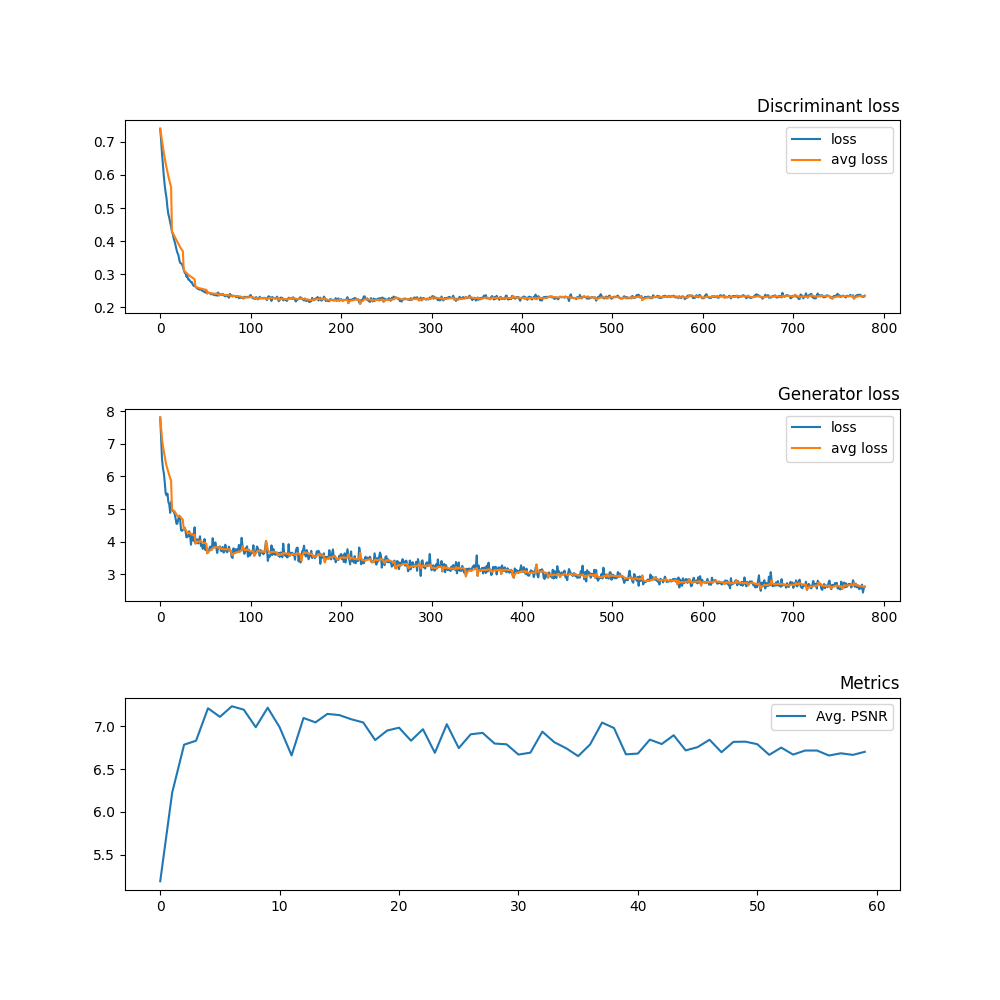

<IPython.core.display.Javascript object>


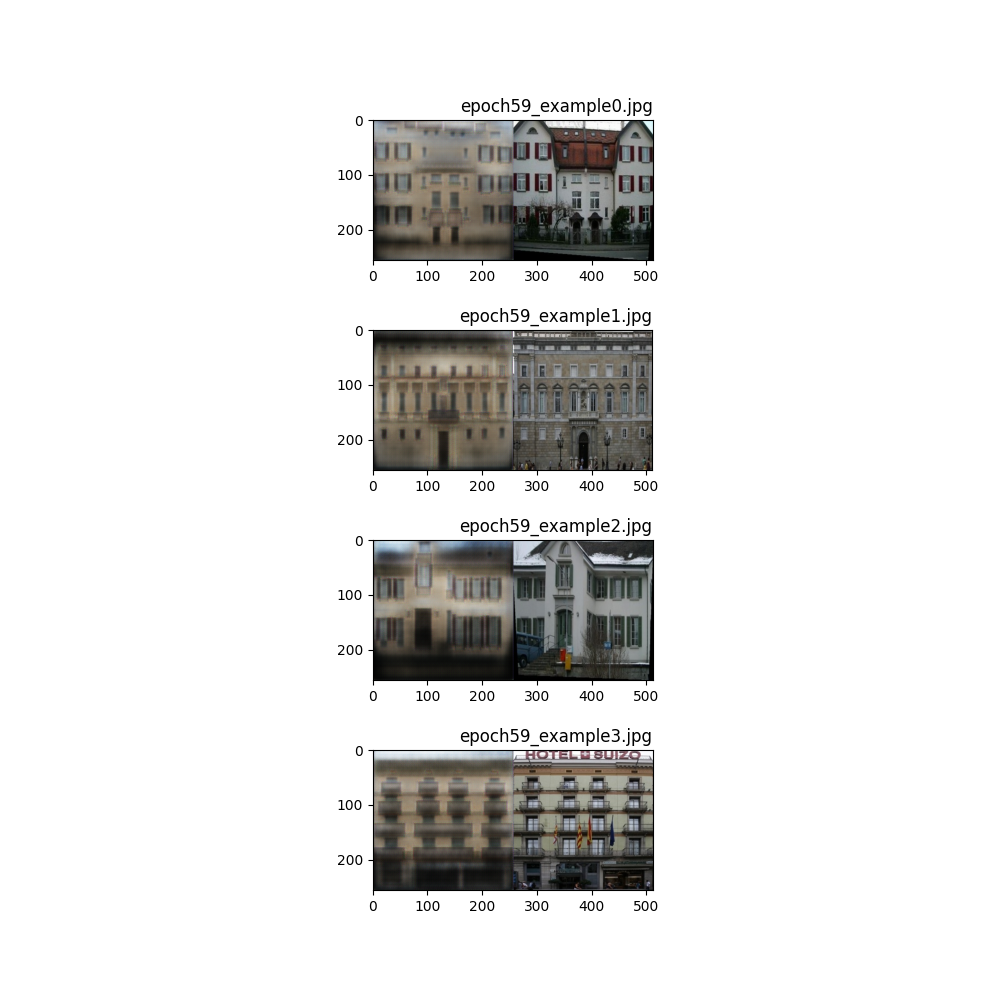

In [7]:
%matplotlib notebook


iteration = 0
for epoch in range(num_epochs):
    gen_scheduler.step()
    disc_scheduler.step()
    loss_d_ = []
    loss_g_ = []
    for idx, batch in enumerate(train_dataloader):
        real_a, real_b = batch[0].to(device), batch[1].to(device)
        fake_b = gen(real_a)

        ######################
        # (1) Update D network
        ######################
        set_requires_grad(disc, True)
        disc_optimizer.zero_grad()
        
        # train with fake
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = disc.forward(fake_ab.detach())
        loss_d_fake = criterionGAN(pred_fake, False)

        # train with real
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = disc.forward(real_ab)
        loss_d_real = criterionGAN(pred_real, True)
        
        # Combined D loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5

        loss_d.backward()
       
        disc_optimizer.step()

        ######################
        # (2) Update G network
        ######################
        set_requires_grad(disc, False)
        gen_optimizer.zero_grad()

        # First, G(A) should fake the discriminator
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = disc.forward(fake_ab)
        loss_g_gan = criterionGAN(pred_fake, True)

        # Second, G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * 10
        
        loss_g = loss_g_gan + loss_g_l1
        
        loss_g.backward()

        gen_optimizer.step()
        loss_d_.append(loss_d.item())
        loss_g_.append(loss_g.item())
        dynamic_plot.update('Discriminant loss_loss', iteration, loss_d.item())
        dynamic_plot.update('Discriminant loss_avg loss', iteration, np.mean(loss_d_))
        dynamic_plot.update('Generator loss_loss', iteration, loss_g.item())
        dynamic_plot.update('Generator loss_avg loss', iteration, np.mean(loss_g_))
        dynamic_plot.draw()
        iteration += 1

    # test
    gen.eval()
    disc.eval()
    with torch.no_grad():
        avg_psnr = 0
        for batch in test_dataloader:
            input, target = batch[0].to(device), batch[1].to(device)

            prediction = gen(input)
            mse = criterionMSE(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
        dynamic_plot.update('Metrics_Avg. PSNR', epoch, avg_psnr / len(test_dataloader))
        dynamic_plot.draw()
        
        examples = [test_dataset[example_idx] for example_idx in random.sample(range(len(test_dataset)), examples_num)]
        examples = [StyleDataset.tensor2image(gen(_[0].to(device).unsqueeze(0))[0].cpu(), _[1]) for _ in examples]
        for example_idx in range(len(examples)):
            name = 'epoch{}_example{}.jpg'.format(epoch, example_idx)
            dynamic_image.update(name, examples[example_idx])
            
        dynamic_image.draw()
    gen.train()
    disc.train()

# CycleGan

In [6]:
class NLayerDiscriminator(nn.Module):

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        super(NLayerDiscriminator, self).__init__()
        use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

class ResnetGenerator(nn.Module):

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out    
    

class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        self.num_imgs = 0
        self.images = []

    def query(self, images):
        if self.pool_size == 0:  # if the buffer size is 0, do nothing
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:   # if the buffer is not full; keep inserting current images to the buffer
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:  # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
                    random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:       # by another 50% chance, the buffer will return the current image
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)   # collect all the images and return
        return return_images

In [13]:
device = 'cuda:0'
lr_base = 3e-4
num_epochs = 90
dynamic_plot = DynamicPlot()
examples_num = 4
dynamic_image = DynamicImage(examples_num)
# examples_path = 'facades/examples'
# Path(examples_path).mkdir(parents=True, exist_ok=True)
# examples_num = 4


train_dataset = StyleDataset('facades/train', flip_p=0.5)
val_dataset = StyleDataset('facades/val', flip_p=0)
test_dataset = StyleDataset('facades/test', flip_p=0)

train_dataloader = DataLoader(dataset=train_dataset, num_workers=8, batch_size=8, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, num_workers=4, batch_size=8, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, num_workers=4, batch_size=8, shuffle=False)

fake_a_pool = ImagePool(32)  # create image buffer to store previously generated images
fake_b_pool = ImagePool(32)  # create image buffer to store previously generated images

gen_a = nn.DataParallel(ResnetGenerator(3, 3, n_blocks=9), device_ids=[0,1,2,3,4,5,6,7]).cuda()
gen_b = nn.DataParallel(ResnetGenerator(3, 3, n_blocks=9), device_ids=[0,1,2,3,4,5,6,7]).cuda()
disc_a = nn.DataParallel(NLayerDiscriminator(3), device_ids=[0,1,2,3,4,5,6,7]).cuda()
disc_b = nn.DataParallel(NLayerDiscriminator(3), device_ids=[0,1,2,3,4,5,6,7]).cuda()

gen_optimizer = torch.optim.Adam(params=itertools.chain(gen_a.parameters(), gen_b.parameters()), lr=lr_base)
disc_optimizer = torch.optim.Adam(params=itertools.chain(disc_a.parameters(), disc_b.parameters()), lr=lr_base)

gen_scheduler = torch.optim.lr_scheduler.StepLR(gamma=0.5, step_size=30, optimizer=gen_optimizer)
disc_scheduler = torch.optim.lr_scheduler.StepLR(gamma=0.5, step_size=30, optimizer=disc_optimizer)

criterionGAN = GANLoss().to(device)
criterionCycle = torch.nn.L1Loss()
criterionIdt = torch.nn.L1Loss()
criterionMSE = nn.MSELoss().to(device)


lambda_idt = 0.0
lambda_A = 10.0
lambda_B = 10.0

<IPython.core.display.Javascript object>


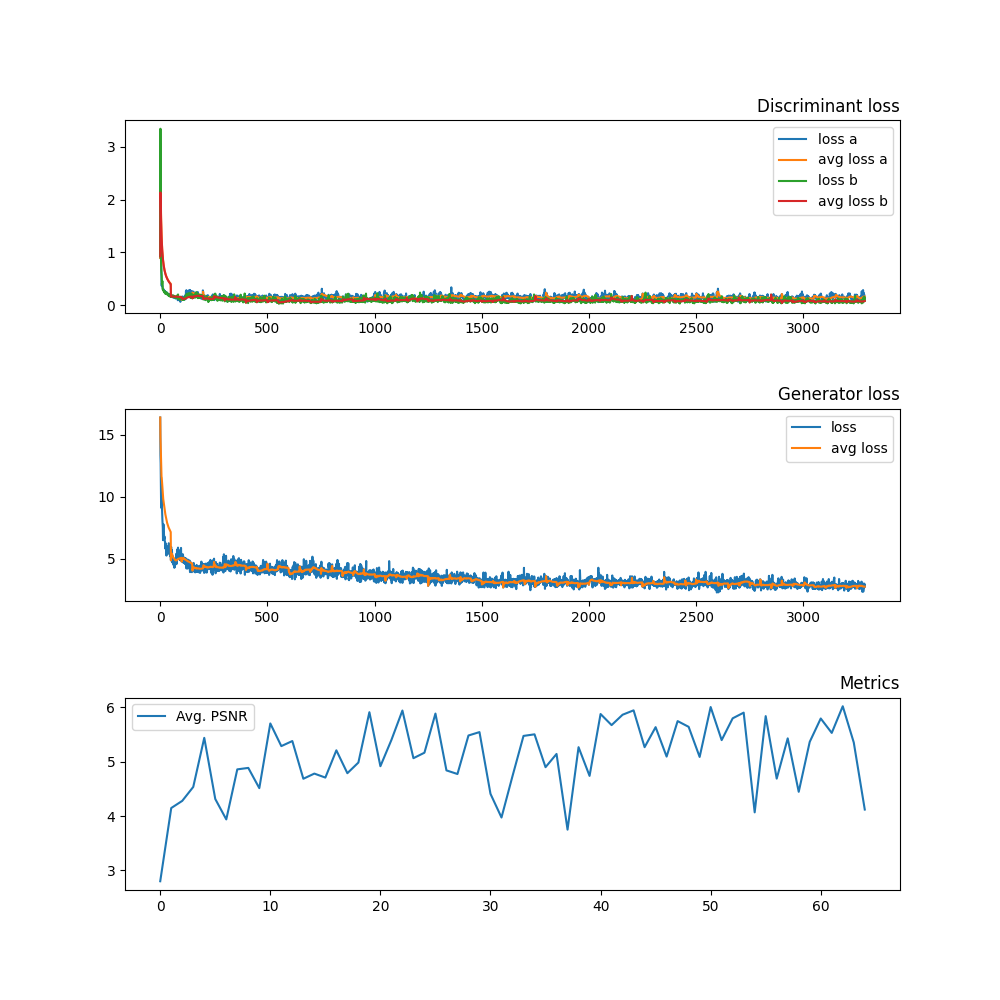

<IPython.core.display.Javascript object>


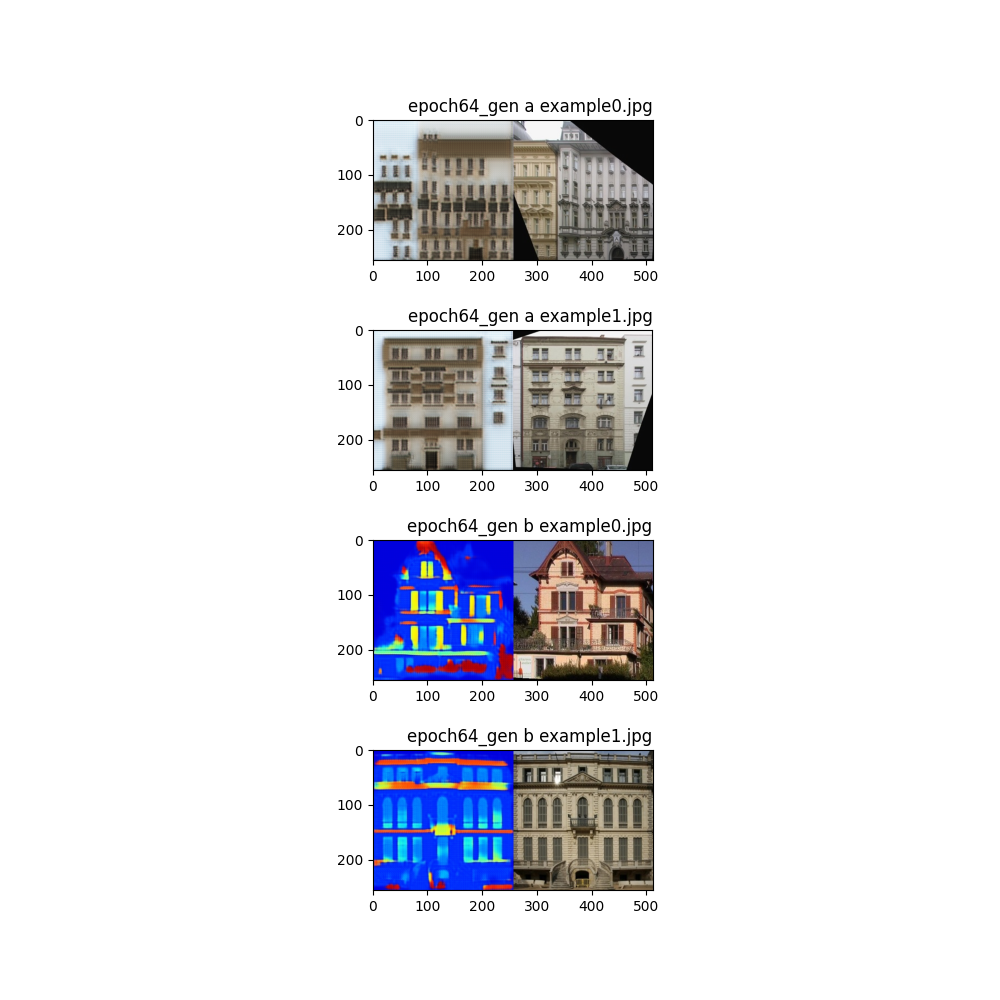

In [ ]:
%matplotlib notebook


iteration = 0
for epoch in range(num_epochs):
    gen_scheduler.step()
    disc_scheduler.step()
    loss_d_a_ = []
    loss_d_b_ = []
    loss_g_ = []
    for idx, batch in enumerate(train_dataloader):
        real_a, real_b = batch[0].to(device), batch[1].to(device)
        fake_b = gen_a(real_a)  # G_A(A)
        rec_a = gen_b(fake_b)   # G_B(G_A(A))
        fake_a = gen_b(real_b)  # G_B(B)
        rec_b = gen_a(fake_a)   # G_A(G_B(B))

        ######################
        # (1) Update G networks
        ######################
        set_requires_grad([disc_a, disc_b], False)
        gen_optimizer.zero_grad()
        
        
        if lambda_idt > 0:
            idt_a = gen_a(real_b)
            loss_idt_a = criterionIdt(idt_a, real_b) * lambda_B * lambda_idt

            idt_b = gen_b(real_a)
            loss_idt_b = criterionIdt(idt_b, real_a) * lambda_A * lambda_idt
        else:
            loss_idt_a = 0
            loss_idt_b = 0
        
        
        loss_g_a = criterionGAN(disc_a(fake_b), True)
        # GAN loss D_B(G_B(B))
        loss_g_b = criterionGAN(disc_b(fake_a), True)
        # Forward cycle loss || G_B(G_A(A)) - A||
        loss_cycle_a = criterionCycle(rec_a, real_a) * lambda_A
        # Backward cycle loss || G_A(G_B(B)) - B||
        loss_cycle_b = criterionCycle(rec_b, real_b) * lambda_B
        # combined loss and calculate gradients
        loss_g = loss_g_a + loss_g_b + loss_cycle_a + loss_cycle_b + loss_idt_a + loss_idt_b
        loss_g.backward()
        
        gen_optimizer.step()

        ######################
        # (2) Update D networks
        ######################
        set_requires_grad([disc_a, disc_b], True)
        disc_optimizer.zero_grad()
        
        
        fake_b_ = fake_b_pool.query(fake_b)
        
        pred_real = disc_a(real_b)
        loss_d_real = criterionGAN(pred_real, True)
        # Fake
        pred_fake = disc_a(fake_b_.detach())
        loss_d_fake = criterionGAN(pred_fake, False)
        # Combined loss and calculate gradients
        loss_d_a = (loss_d_real + loss_d_fake) * 0.5
        loss_d_a.backward()
                
        fake_a_ = fake_a_pool.query(fake_a)
        
        pred_real = disc_b(real_a)
        loss_d_real = criterionGAN(pred_real, True)
        # Fake
        pred_fake = disc_b(fake_a_.detach())
        loss_d_fake = criterionGAN(pred_fake, False)
        # Combined loss and calculate gradients
        loss_d_b = (loss_d_real + loss_d_fake) * 0.5
        loss_d_b.backward()
        
        disc_optimizer.step()
        
        loss_d_a_.append(loss_d_a.item())
        loss_d_b_.append(loss_d_b.item())
        loss_g_.append(loss_g.item())
        dynamic_plot.update('Discriminant loss_loss a', iteration, loss_d_a.item())
        dynamic_plot.update('Discriminant loss_avg loss a', iteration, np.mean(loss_d_a_))
        dynamic_plot.update('Discriminant loss_loss b', iteration, loss_d_b.item())
        dynamic_plot.update('Discriminant loss_avg loss b', iteration, np.mean(loss_d_b_))
        dynamic_plot.update('Generator loss_loss', iteration, loss_g.item())
        dynamic_plot.update('Generator loss_avg loss', iteration, np.mean(loss_g_))
        dynamic_plot.draw()
        iteration += 1

    # test
    gen_a.eval()
    gen_b.eval()
    with torch.no_grad():
        avg_psnr = 0
        for batch in test_dataloader:
            input, target = batch[0].to(device), batch[1].to(device)

            prediction = gen_a(input)
            mse = criterionMSE(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
        dynamic_plot.update('Metrics_Avg. PSNR', epoch, avg_psnr / len(test_dataloader))
        dynamic_plot.draw()
        
        examples_a = [test_dataset[example_idx] for example_idx in random.sample(range(len(test_dataset)), examples_num // 2)]
        examples_b = [test_dataset[example_idx] for example_idx in random.sample(range(len(test_dataset)), examples_num // 2)]
        examples_a = [StyleDataset.tensor2image(gen_a(_[0].to(device).unsqueeze(0))[0].cpu(), _[1]) for _ in examples_a]
        examples_b = [StyleDataset.tensor2image(gen_b(_[1].to(device).unsqueeze(0))[0].cpu(), _[1]) for _ in examples_b]
        for example_idx in range(len(examples_a)):
            name = 'epoch{}_gen a example{}.jpg'.format(epoch, example_idx)
            dynamic_image.update(name, examples_a[example_idx])
        for example_idx in range(len(examples_b)):
            name = 'epoch{}_gen b example{}.jpg'.format(epoch, example_idx)
            dynamic_image.update(name, examples_b[example_idx])
            
        dynamic_image.draw()
    gen_a.train()
    gen_b.train()